In [1]:
import sys
sys.path.append("..")

import csaf
import csaf.utils as csafutils

from f16lib.systems import F16AcasShield, F16AcasShieldSurrogate

import GPy

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
F16AcasShield().components['autopilot'].default_initial_values
F16AcasShield().components['autopilot'].inputs

(('inputs_own', f16lib.messages.F16PlantStateMessage),
 ('inputs_intruder0', f16lib.messages.F16PlantStateMessage),
 ('inputs_intruder1', f16lib.messages.F16PlantStateMessage))

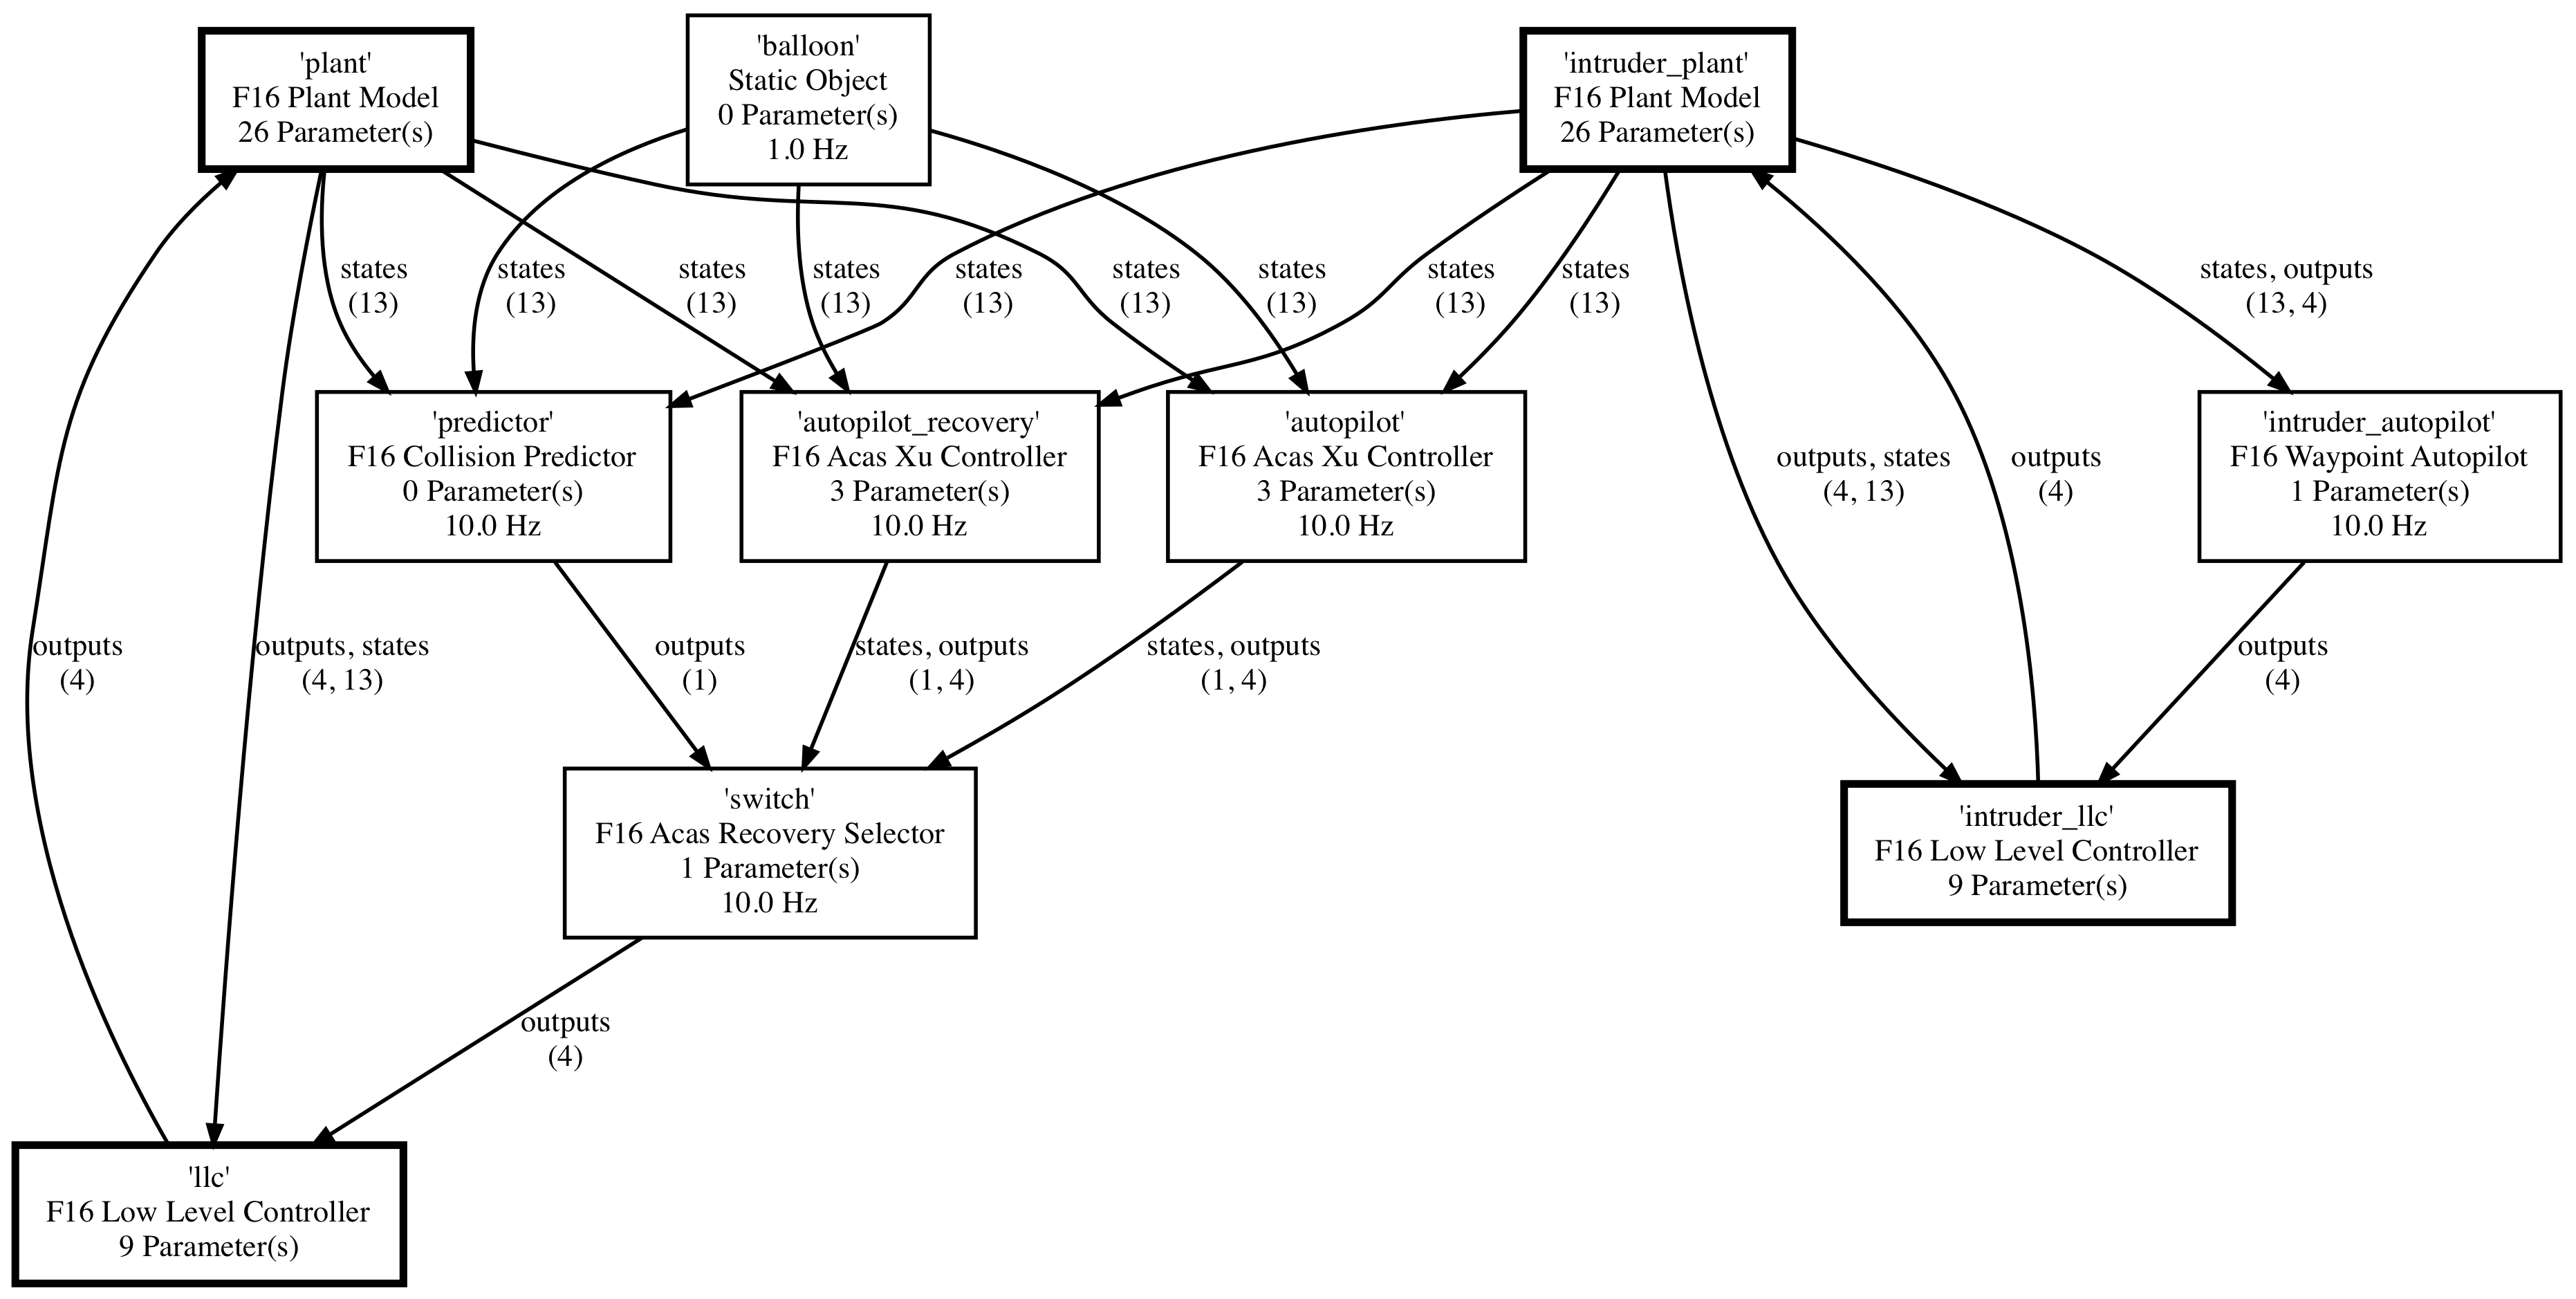

In [3]:
# check the system
F16AcasShield().check()

# view the system
csafutils.view_block_diagram(F16AcasShield, ipython_notebook=True)

In [4]:
def air_collision_condition(ctraces):
        """ground collision premature termination condition
        """
        # get the aircraft states
        sa, sb = ctraces['plant']['states'], ctraces['intruder_plant']['states']
        if sa and sb:
            # look at distance between last state
            return (np.linalg.norm(np.array(sa[-1][9:11]) - np.array(sb[-1][9:11]))) < 100

In [5]:
# create pub/sub components out of the configuration
my_system = F16AcasShield()
my_system.check()

# set the scenario states
my_system.set_state('plant', [800.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6000.0, 9.0])
my_system.set_state('intruder_plant', [370.0, 0.0, 0.0, 0.0, 0.0, np.pi, 0.0, 0.0, 0.0, 8000.0, 0.0, 6000.0, 9.0])
my_system.components['intruder_autopilot'].waypoints = [(-1200, 5000, 1000), (-500, 5000, 1000)]

In [6]:
trajs = my_system.simulate_tspan((0, 30.0), show_status=True)

100%|█████████████████████████████████████| 5130/5130 [00:03<00:00, 1675.73it/s]


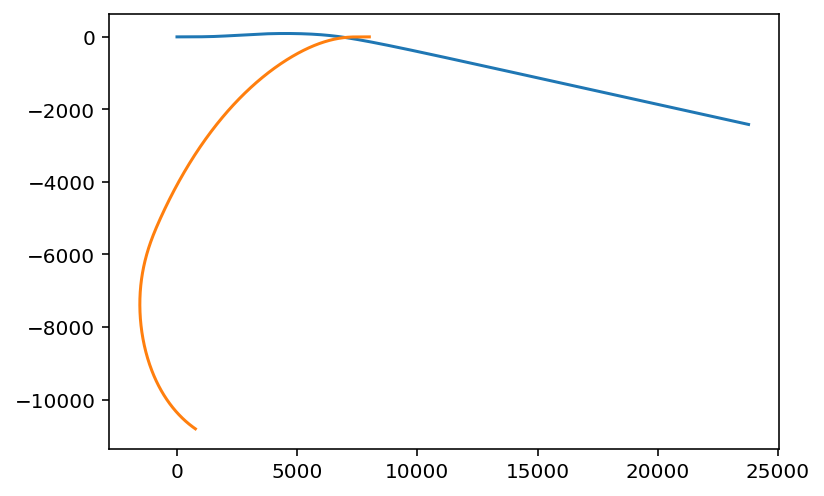

In [7]:
plt.plot(*np.array(trajs["plant"].states)[:, 9:11].T)
plt.plot(*np.array(trajs["intruder_plant"].states)[:, 9:11].T)

In [8]:
my_system = F16AcasShield()
my_system.check()
# set the scenario states
my_system.set_state('plant', [800.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6000.0, 9.0])
my_system.set_state('intruder_plant', [370.0, 0.0, 0.0, 0.0, 0.0, np.pi, 0.0, 0.0, 0.0, 8000.0, 0.0, 6000.0, 9.0])
my_system.components['intruder_autopilot'].waypoints = [(1200, 5000, 1000), (-500, 20000, 1000)]
trajsp = my_system.simulate_tspan((0, 50.0), show_status=True)

100%|█████████████████████████████████████| 8554/8554 [00:04<00:00, 1824.31it/s]


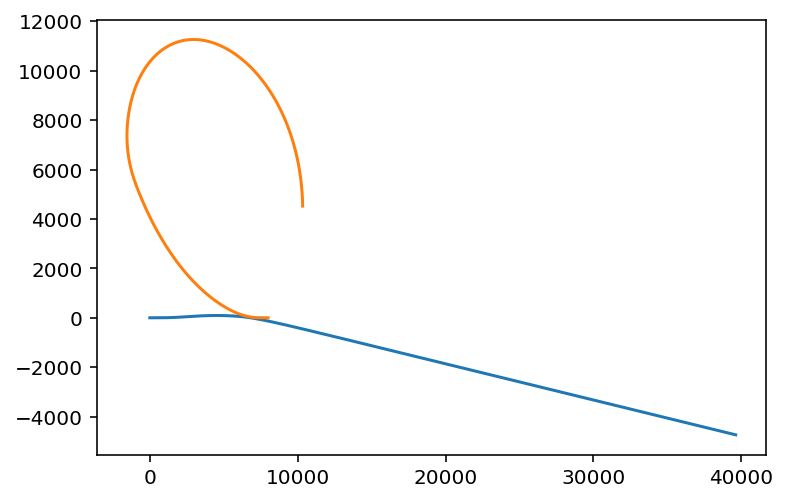

In [9]:
plt.plot(*np.array(trajsp["plant"].states)[:, 9:11].T)
plt.plot(*np.array(trajsp["intruder_plant"].states)[:, 9:11].T)

In [10]:
# create an environment from the system, allowing us to act as the controller
class F16AcasShieldEnv(csaf.SystemEnv):
    system_type = F16AcasShield
    agents = ["predictor"]
    
my_env = F16AcasShieldEnv(terminating_conditions_all=air_collision_condition)
# set the scenario states
my_env.set_state('plant', [500.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6000.0, 9.0])
my_env.set_state('intruder_plant', [500.0, 0.0, 0.0, 0.0, 0.0, np.pi, 0.0, 0.0, 0.0, 4000.0, 0.0, 6000.0, 9.0])

In [11]:
from collections import deque


class PredictorBuffer:
    # number of steps to take before re-running predictor
    n_steps = 5
    
    def __init__(self, env: csaf.SystemEnv):
        self.pstates = []
        self.init_out = [0.,0.,0.,0.7]
        self.env = env
        self._finished = False
        
    def step(self, pred_out = False):
        """step through the simulation for n steps and collect a buffer for prediction"""
        for _ in range(self.n_steps):
            try:
                # send the outputs, can collect the inputs
                ctime, comp_input = self.env.step({"outputs": [pred_out]}) 

                # get the states and track them over time
                self.pstates.append((comp_input))

            # stop iteration occurs when the termination conditions are satisfied
            except StopIteration as e:
                self._finished = True
                break

            # other errors can occur -- maybe solver error
            except Exception as e:
                self._finished = True
                raise e
                break
      
    @property
    def buffer(self) -> np.array:
        """get the buffer as a numpy array"""
        return np.array(self.pstates)
                
    @property
    def is_finished(self):
        """if simulation terminated"""
        return self._finished
    

In [12]:
# create a buffer for the predictor
pb = PredictorBuffer(my_env)

# fill it
pb.step(False)
pb.step(False)

# get buffer
pstates = pb.buffer

In [13]:
import numpy as np

In [14]:
import typing
def generate_surrogate_system(predictors: typing.Tuple[GPy.core.model.Model, GPy.core.model.Model]):
    """create the 'digital twin' used by the predictor component"""
    # import relevant f16 objects
    from f16lib.messages import F16ControllerOutputMessage, F16PlantOutputMessage, F16PlantStateMessage
    from f16lib.components import f16_xequil
    from f16lib.systems import F16AcasShieldSurrogate
    
    # infer flows from the GP predictors
    def surrogate_state_update(model, t, states, inputs):
        state = list(f16_xequil.copy())
        state[9:11] = [predictor.predict(np.array([[t]]))[0][0][0] for predictor in predictors]
        return state
    
    def surrogate_output(model, t, states, inputs):
        return [0.0, 0.0, 0.0, 0.0]
    
    # create the surrogate model component
    class _IntruderSurrogateComponent(csaf.DiscreteComponent):
        name = "F16 Surrogate Model"
        sampling_frequency = 10.0
        default_parameters = {}
        inputs = ()
        outputs = (
            ("outputs", F16PlantOutputMessage),
        )
        states = F16PlantStateMessage
        default_initial_values = {
            "states": f16_xequil        
        }
        flows = {
            "outputs": surrogate_output,
            "states": surrogate_state_update
        }
        
    # bring the component into a system
    class _SurrogateSystem(F16AcasShieldSurrogate):
        components = {**F16AcasShieldSurrogate.components, 
                      **{"intruder_plant": _IntruderSurrogateComponent}}
        
    return _SurrogateSystem


In [40]:
def prod_kernel():
    kern0 = GPy.kern.RBF(1, lengthscale=40, variance=5)
    kern1 = GPy.kern.Spline(1, c=20, variance=5)
    kern0.lengthscale.fix()
    kern = GPy.kern.Prod([kern0, kern1])
    return kern


def make_predictors(tspan, pstates, idx=0):
    tt = np.array(tspan)[:, np.newaxis]
    xt = (pstates[:, 9+13*idx])[:, np.newaxis]
    yt = (pstates[:, 10+13*idx])[:, np.newaxis]
    mx = GPy.models.GPRegression(tt, xt, prod_kernel(), normalizer=True)
    my = GPy.models.GPRegression(tt, yt, prod_kernel(), normalizer=True)
    mx.optimize()
    my.optimize()
    return mx, my


t = np.arange(0, len(pstates), 1) / 10
predictors = make_predictors([*t, 15], np.vstack((pb.buffer, [*[0.0,]*9,*(-1200, 5000, 1000), 0]*3)), 1)
#predictors[0].optimize(messages=1, ipython_notebook=True)

In [18]:
([*[0.0,]*9,*(-1200, 5000, 1000), 0]*2)[9+13:11+13]

[-1200, 5000]

In [19]:
surrogate_f16 = generate_surrogate_system(predictors)

In [32]:
surr_sys = surrogate_f16()
surr_sys.check()

True

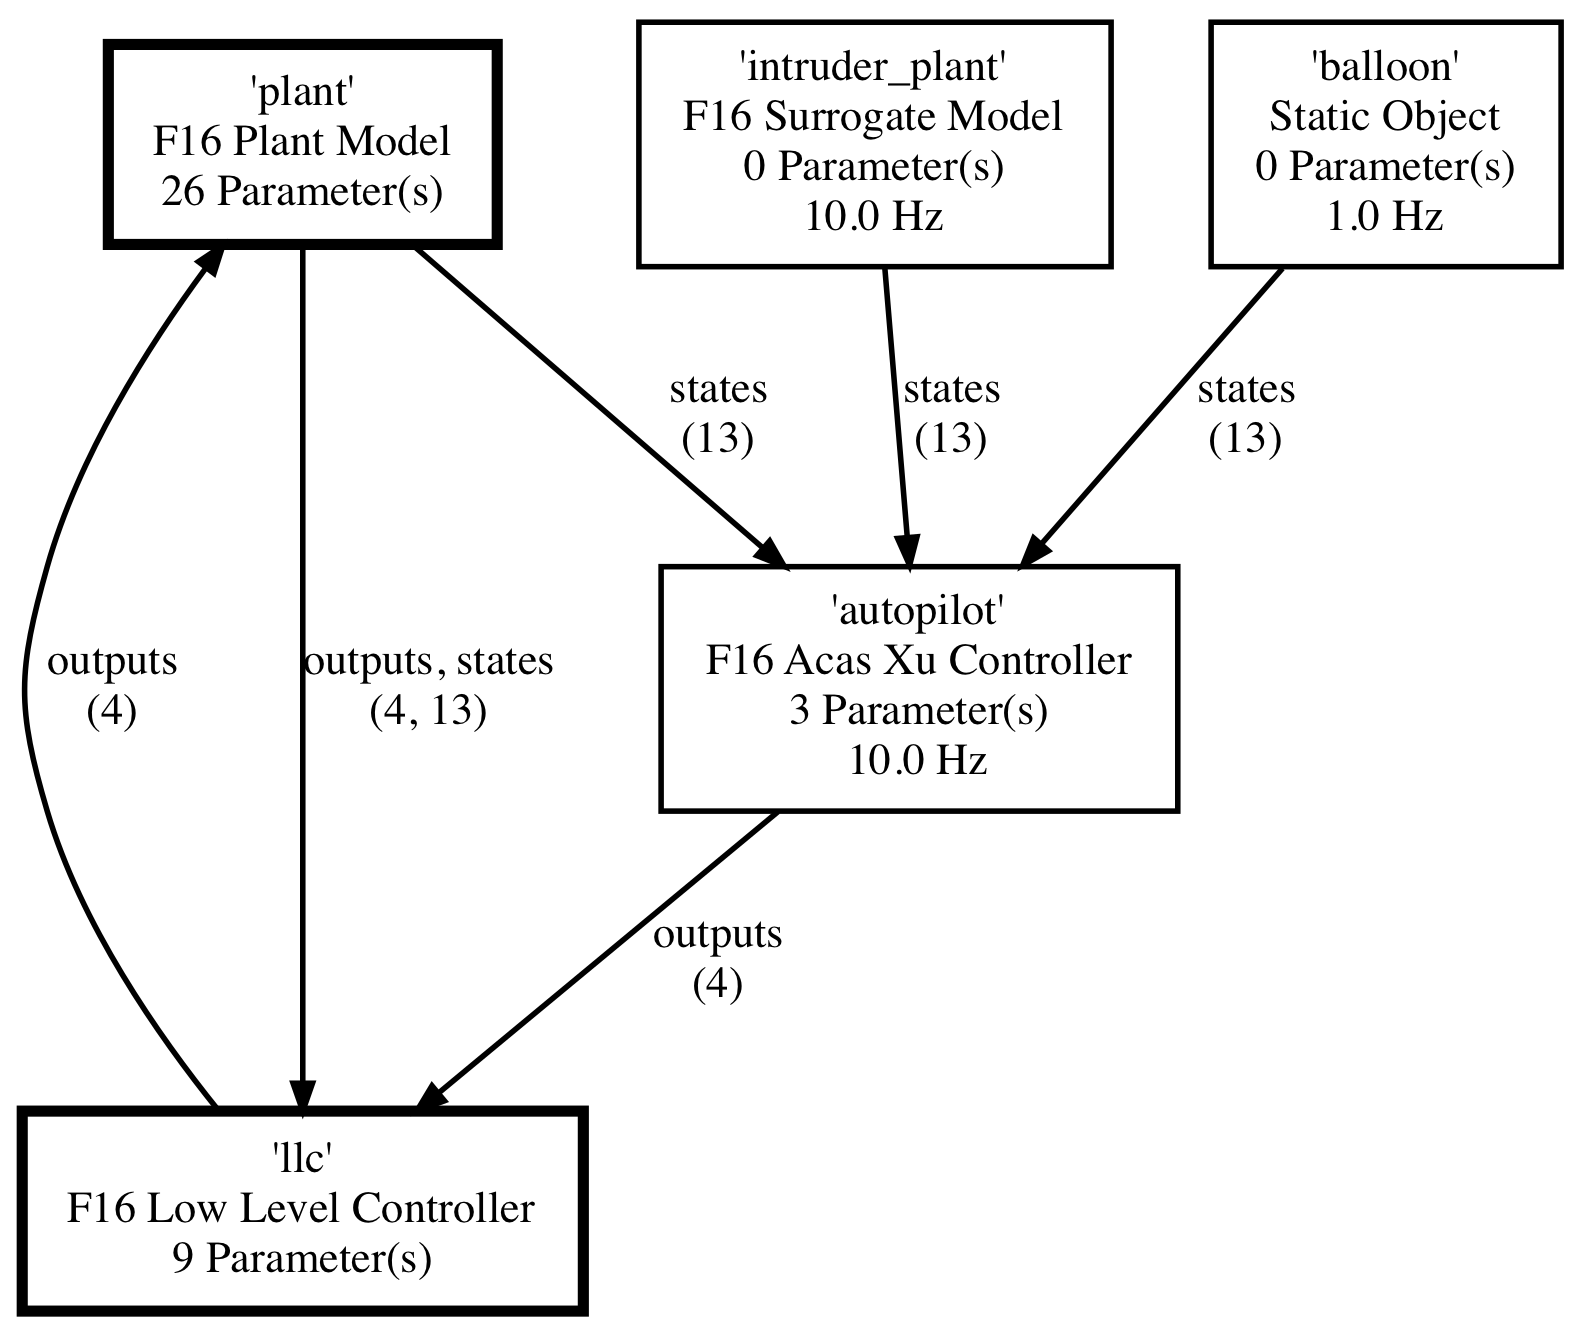

In [33]:
# view the system
csafutils.view_block_diagram(surr_sys, ipython_notebook=True)

In [35]:
def predict(tspan, pstates, predictors, idx=0):
    tt = (np.arange(0, len(pstates), 1) / 10)[:, np.newaxis]
    xt = (pstates[:, 9+13*idx])[:, np.newaxis]
    yt = (pstates[:, 10+13*idx])[:, np.newaxis]
    mx, my = predictors
    x, xv = mx.predict((np.array(tspan) + len(pstates)/10-0.1)[:, np.newaxis])
    y, yv = my.predict((np.array(tspan) + len(pstates)/10-0.1)[:, np.newaxis])
    return (tt.flatten(), xt.flatten(), yt.flatten()), (x.flatten(), xv.flatten()), (y.flatten(), yv.flatten())


alt_conf = surr_sys


def predict_ownship(tspan, pstates, idx=0):
    tt = (np.arange(0, len(pstates), 1) / 10)[:, np.newaxis]
    xt = (pstates[:, 9+idx*13])[:, np.newaxis]
    yt = (pstates[:, 10+idx*13])[:, np.newaxis]
    
    tr = min(tspan), max(tspan)
    
    # create pub/sub components out of the configuration
    alt_system = F16AcasShield()#csys.System.from_config(alt_conf)

    # set the scenario states
    alt_system.set_state('plant', pstates[-1, :13])
    alt_system.set_state('intruder_plant', pstates[-1, 13:26])
    alt_system.set_state('balloon', pstates[-1, 26:39])
    trajs = alt_system.simulate_tspan(tr, 
                                     show_status=False)
    
    x = np.array(trajs['plant'].states)[:, 9]
    xv = np.zeros(x.shape)
    y = np.array(trajs['plant'].states)[:, 10]
    yv = np.zeros(y.shape)
    
    return (tt.flatten(), xt.flatten(), yt.flatten()), \
            (x.flatten(), xv.flatten()), \
            (y.flatten(), yv.flatten())

In [36]:
t = np.linspace(0, 5, 151)
(tp, xp, yp), (x, xv), (y, yv) = predict_ownship(t, pstates)

In [37]:
def plot_results(ax, ret, color):
    (tp, xp, yp), (x, xv), (y, yv) = ret
    ax[0].plot(tp, xp, color)
    ax[0].plot(t+tp[-1], x, color)
    ax[0].fill_between(t+tp[-1], x+2*np.sqrt(xv), x-2*np.sqrt(xv), alpha=0.2, color=color)
    ax[0].grid()
    
    
    ax[1].plot(tp, yp, color)
    ax[1].plot(t+tp[-1], y, color)
    ax[1].fill_between(t+tp[-1], y+2*np.sqrt(yv), y-2*np.sqrt(yv), alpha=0.2, color=color)
    ax[1].set_ylabel("y")
    ax[1].grid()

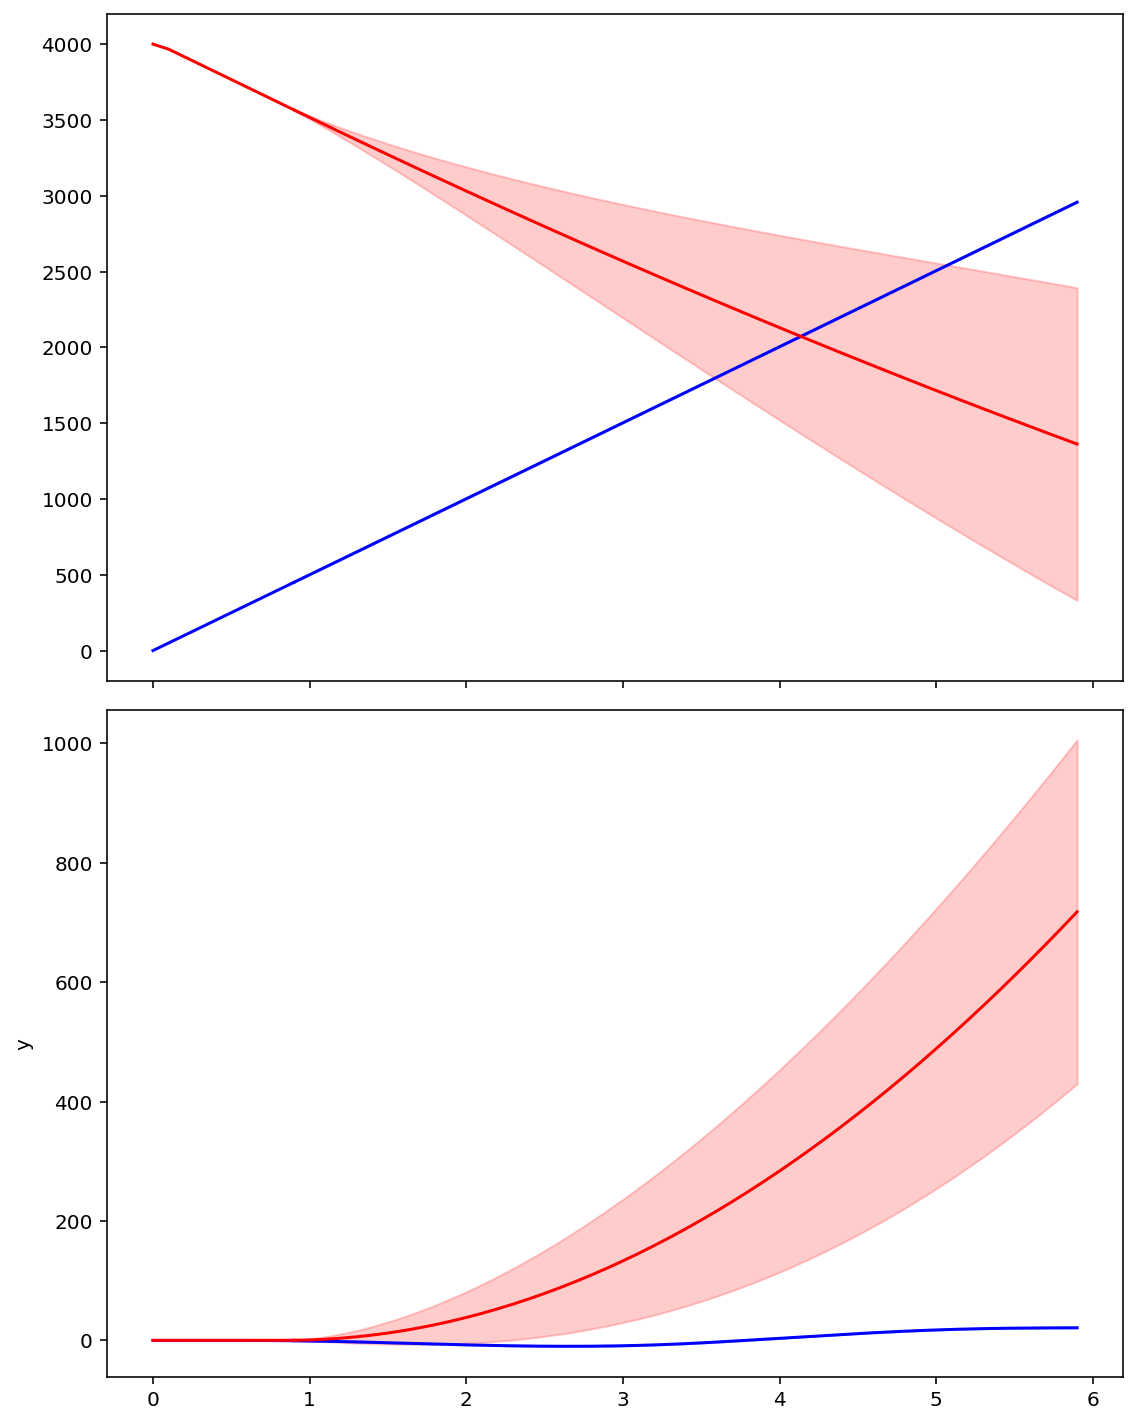

In [38]:
fig, ax = plt.subplots(figsize=(8, 10), nrows=2, sharex=True)
plot_results(ax, predict_ownship(t, pb.buffer, 0), 'b')
plot_results(ax, predict(t, pb.buffer, predictors, 1), 'r')
plt.tight_layout()